<a href="https://colab.research.google.com/github/Sruthyb/RIO-125-TCS-iON/blob/main/Time_series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting System - Project Demand of Products at a Retail Outlet Based on historical data

In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

!pip install Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --upgrade xlrd

In [4]:
#reading data to python environment
pd.set_option('display.max_columns', 9994)
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/TCS-intern/Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Exploratory Data Analysis

In [ ]:
df.shape

(9994, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [ ]:
df.corr()['Sales']

Row ID        -0.001359
Postal Code   -0.023854
Sales          1.000000
Quantity       0.200795
Discount      -0.028190
Profit         0.479064
Name: Sales, dtype: float64

other Features have no correlation with the sales feature.

## Indexing time series data

In [5]:
df = df.set_index(['Order Date'])

In [6]:
df.index.min(), df.index.max()

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

 #### Note:
 - The dataset used for this project is a superstore data from 2014 to 2018 containing 9994 entries and 21 features and this is a time series data.
 - Dataset contains object, float and integer Data types and the date columns are already in datetime format.
 - there is no feature having strong correlation with sales feature.
 - For forecasting, we are using mainly the Sales Data with the order data of different product categories.

## Visualising Data

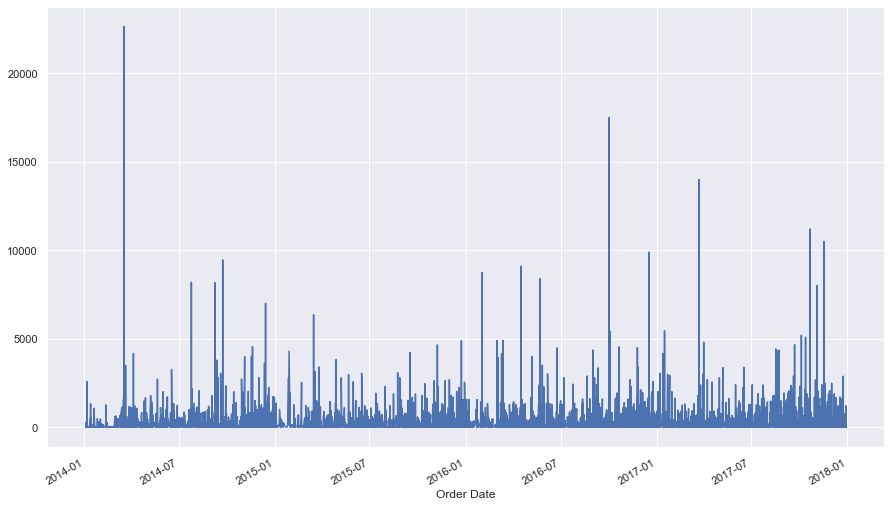

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
df['Sales'].plot();

## Resampling Data

Order Date
2014-01-01    180.213861
2014-02-01     98.258522
2014-03-01    354.719803
2014-04-01    209.595148
2014-05-01    193.838418
2014-06-01    256.260204
2014-07-01    237.387364
2014-08-01    182.414827
2014-09-01    305.139369
2014-10-01    197.820082
2014-11-01    247.260115
2014-12-01    250.164103
2015-01-01    313.346131
2015-02-01    186.740797
2015-03-01    280.625014
2015-04-01    213.720053
2015-05-01    206.381414
2015-06-01    179.690522
2015-07-01    205.466607
2015-08-01    232.064982
2015-09-01    220.463884
2015-10-01    189.186286
2015-11-01    234.483221
2015-12-01    237.087092
2016-01-01    208.342596
2016-02-01    276.853193
2016-03-01    317.275307
2016-04-01    227.941406
2016-05-01    253.278791
2016-06-01    202.736352
2016-07-01    195.333149
2016-08-01    176.791899
2016-09-01    202.231474
2016-10-01    304.529311
2016-11-01    214.626935
2016-12-01    275.565463
2017-01-01    283.686284
2017-02-01    189.730219
2017-03-01    247.362827
2017-04-01    

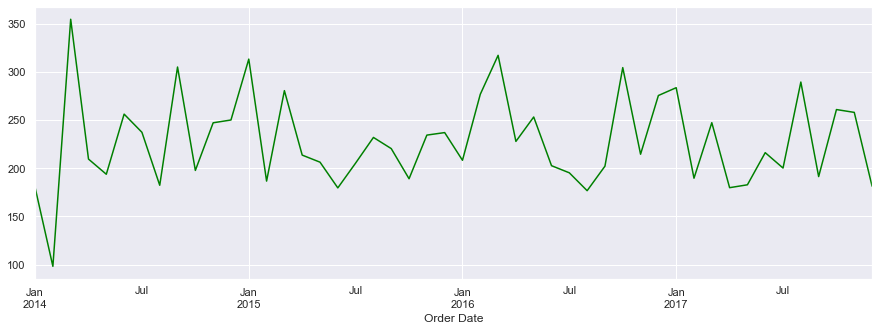

In [ ]:
#monthly mean sales begin
mean_monthlysales = df.resample(rule='MS').mean()['Sales']
print(mean_monthlysales)
mean_monthlysales.plot(figsize=(15,5),c='green')
plt.show()

 #### Note:
 - Mean monthly sales is maximum in month march of year 2014. 
 - Also on month sep 2014, jan 2015, march 2016, oct 2016 shows higher sales.
 - There is a huge dip in the graph during feb 2014 which shows least sales.

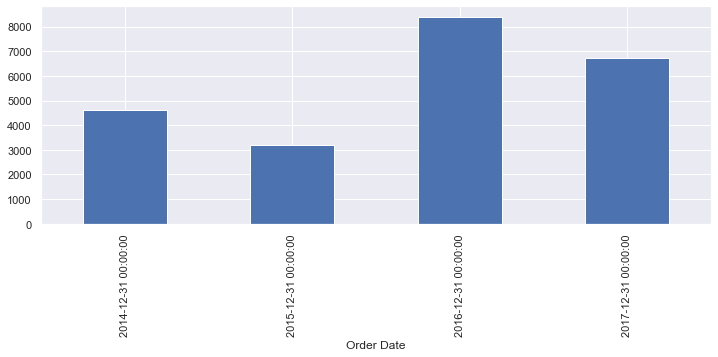

In [ ]:
df.resample(rule='A').max()['Profit'].plot(kind='bar', figsize = (12,4))
plt.show()

###### Note: maximum profit is observed in the year 2016 and least in the year 2015.

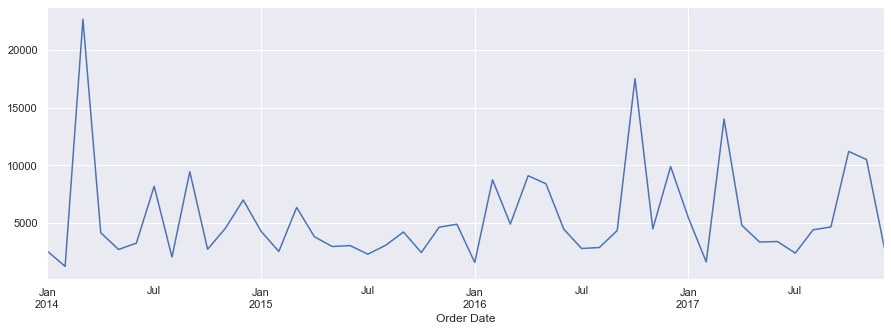

In [ ]:
#MAX MONTHLY SALES
df.resample(rule='M').max()['Sales'].plot(figsize= (15,5))
plt.show()

#### Note: Eventhough, Maximum sales observed to be in year 2014 profit is more on year 2016 as seen from above two graphs.

## Data Pre-processing

In [ ]:
#checking for unique values in columns
{column: len(df[column].unique()) for column in df.columns}

{'Row ID': 9994,
 'Order ID': 5009,
 'Ship Date': 1334,
 'Ship Mode': 4,
 'Customer ID': 793,
 'Customer Name': 793,
 'Segment': 3,
 'Country': 1,
 'City': 531,
 'State': 49,
 'Postal Code': 631,
 'Region': 4,
 'Product ID': 1862,
 'Category': 3,
 'Sub-Category': 17,
 'Product Name': 1850,
 'Sales': 6144,
 'Quantity': 14,
 'Discount': 12,
 'Profit': 7545}

In [7]:
df = df.copy()
#dropping unnecessary columns    
df = df.drop(['Row ID','Country','Customer Name','Product Name','Order ID','Customer ID'],axis=1)

In [ ]:
df.shape

(9994, 14)

In [ ]:
#checking for missing values
df.isna().sum()

Ship Date       0
Ship Mode       0
Segment         0
City            0
State           0
Postal Code     0
Region          0
Product ID      0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

#### Note: The Dataset not containing any missing values.

In [ ]:
#checking different categories in 'category' column
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [ ]:
# Since dataset contain multiple categories of products we have to create seperate Dataframes for each category for analysis.

### FURNITURE

In [8]:
#selecting rows where category is furniture
furniture_data = df.loc[df['Category'] == 'Furniture']
furniture_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.9600,2,0.00,41.9136
2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.9400,3,0.00,219.5820
2015-10-11,2015-10-18,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.5775,5,0.45,-383.0310
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,48.8600,7,0.00,14.1694
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,2015-03-22,First Class,Home Office,Houston,Texas,77041,Central,FUR-BO-10004218,Furniture,Bookcases,383.4656,4,0.32,-67.6704
2016-12-05,2016-12-10,Second Class,Corporate,Newark,Delaware,19711,East,FUR-FU-10002671,Furniture,Furnishings,13.4000,1,0.00,6.4320
2015-09-06,2015-09-09,Second Class,Consumer,Lafayette,Louisiana,70506,South,FUR-TA-10001039,Furniture,Tables,85.9800,1,0.00,22.3548


In [9]:
col = ['Ship Date','Ship Mode','Segment','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Quantity','Discount','Profit']
furniture_data.drop(col,axis=1, inplace=True)

In [10]:
furniture_data.head()

,Sales
Order Date,
2016-11-08,261.9600
2016-11-08,731.9400
2015-10-11,957.5775
2014-06-09,48.8600
2014-06-09,1706.1840


In [11]:
#sorting by order date
furniture_data = furniture_data.sort_values('Order Date')
furniture_data

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940
...,...
2017-12-29,258.750
2017-12-29,1207.840
2017-12-29,101.120


In [13]:
furniture_data.describe()

,Sales
count,2121.000000
mean,349.834887
std,503.179145
min,1.892000
25%,47.040000
50%,182.220000
75%,435.168000
max,4416.174000


In [14]:
furniture_data.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [15]:
#taking monthly mean sales of category furniture
y_furniture = furniture_data['Sales'].resample('MS').mean()

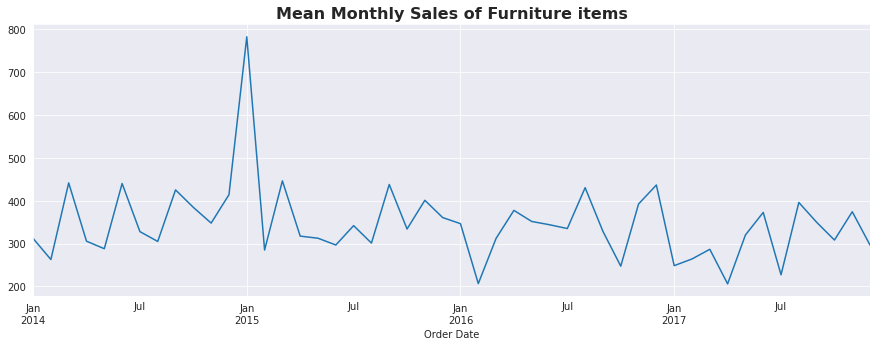

In [16]:
#observing mean monthly sales of furnitures
y_furniture.plot(figsize = (15,5))
plt.title('Mean Monthly Sales of Furniture items', fontsize=16, fontweight='bold')
plt.show()

Note: average sales is maximum at Jan 2015.

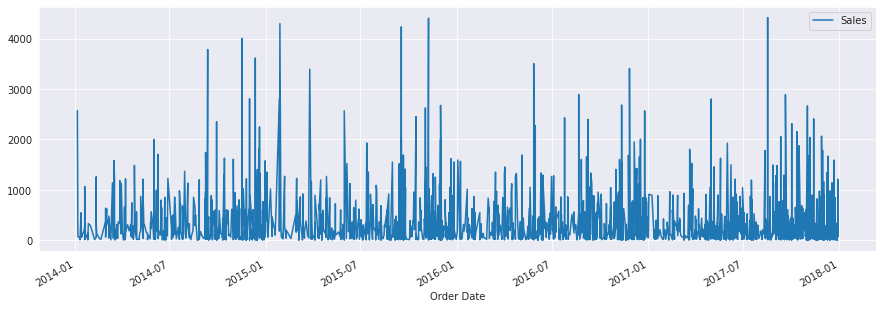

In [17]:
furniture_data.plot(figsize=(15,5))
plt.show()

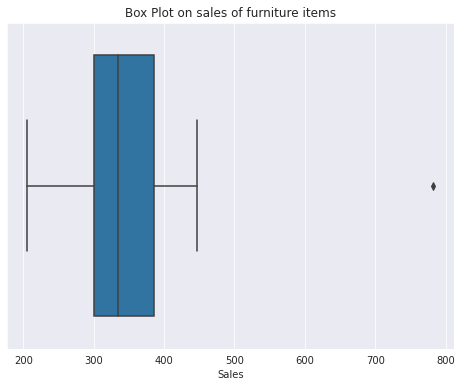

In [18]:
#checking for outliers
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_furniture).set_title('Box Plot on sales of furniture items')
plt.show()

There is one outlier in the furniture data.

### OFFICE SUPPLIES

In [19]:
office_supplies_data = df.loc[df['Category'] == 'Office Supplies']
office_supplies_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.620,2,0.0,6.8714
2015-10-11,2015-10-18,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.368,2,0.2,2.5164
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,7.280,4,0.0,1.9656
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-BI-10003910,Office Supplies,Binders,18.504,3,0.2,5.7825
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-AP-10002892,Office Supplies,Appliances,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-22,2016-09-28,Standard Class,Consumer,Grand Rapids,Michigan,49505,Central,OFF-PA-10002195,Office Supplies,Paper,35.560,7,0.0,16.7132
2015-05-17,2015-05-23,Standard Class,Consumer,Long Beach,New York,11561,East,OFF-LA-10003766,Office Supplies,Labels,31.500,10,0.0,15.1200
2015-05-17,2015-05-23,Standard Class,Consumer,Long Beach,New York,11561,East,OFF-SU-10000898,Office Supplies,Supplies,55.600,4,0.0,16.1240


In [20]:
office_supplies_data.drop(col,axis=1, inplace=True)

In [21]:
office_supplies_data = office_supplies_data.sort_values('Order Date')
office_supplies_data.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,272.736
2014-01-04,11.784
2014-01-04,3.540
2014-01-05,19.536


In [22]:
office_supplies_data.describe()

,Sales
count,6026.000000
mean,119.324101
std,382.182228
min,0.444000
25%,11.760000
50%,27.418000
75%,79.920000
max,9892.740000


In [23]:
office_supplies_data.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-04', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-06', '2014-01-06',
               '2014-01-06', '2014-01-06',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30', '2017-12-30', '2017-12-30',
               '2017-12-30', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=6026, freq=None)

In [24]:
y_office = office_supplies_data['Sales'].resample('MS').mean()

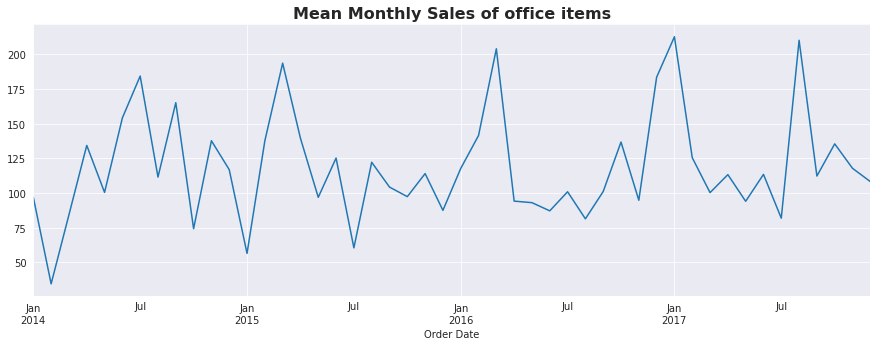

In [25]:
y_office.plot(figsize = (15,5))
plt.title('Mean Monthly Sales of office items', fontsize=16, fontweight='bold')
plt.show()

Sales for office supplies shows maximum at start of year between feb to april and minimum at end of year.

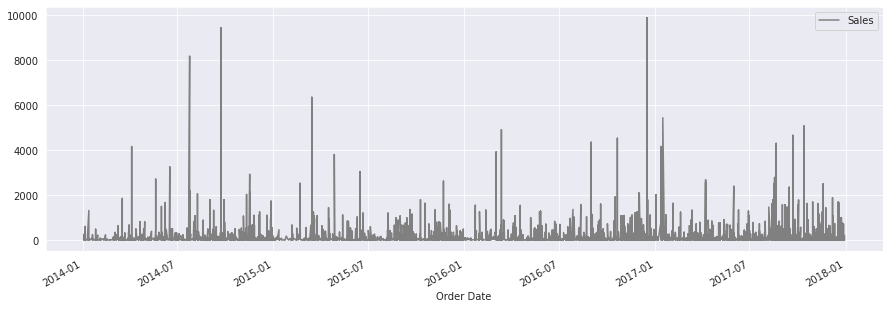

In [26]:
office_supplies_data.plot(figsize=(15,5), c = 'grey')
plt.show()

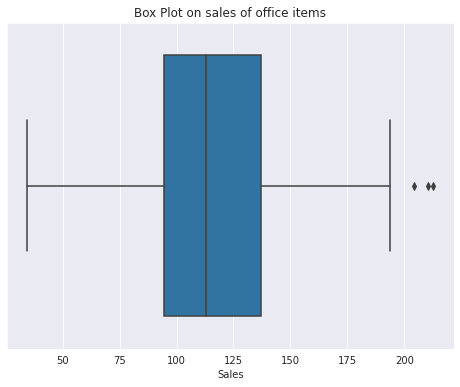

In [27]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_office).set_title('Box Plot on sales of office items')
plt.show()

there are three outliers in the office items data.

## Technology items

In [28]:
technology_data = df.loc[df['Category'] == 'Technology']
technology_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,907.152,6,0.2,90.7152
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,TEC-PH-10002033,Technology,Phones,911.424,4,0.2,68.3568
2014-08-27,2014-09-01,Second Class,Consumer,San Francisco,California,94109,West,TEC-PH-10001949,Technology,Phones,213.480,3,0.2,16.0110
2016-01-16,2016-01-20,Second Class,Consumer,Los Angeles,California,90049,West,TEC-AC-10003027,Technology,Accessories,90.570,3,0.0,11.7741
2016-12-08,2016-12-10,First Class,Corporate,Richardson,Texas,75080,Central,TEC-PH-10004977,Technology,Phones,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-22,2016-09-28,Standard Class,Consumer,Grand Rapids,Michigan,49505,Central,TEC-PH-10001305,Technology,Phones,97.980,2,0.0,27.4344
2016-09-29,2016-10-03,Standard Class,Consumer,Los Angeles,California,90008,West,TEC-AC-10003399,Technology,Accessories,36.240,1,0.0,15.2208
2017-11-17,2017-11-21,Standard Class,Corporate,Athens,Georgia,30605,South,TEC-AC-10001539,Technology,Accessories,79.990,1,0.0,28.7964


In [29]:
technology_data.drop(col,axis=1, inplace=True)

In [30]:
technology_data = technology_data.sort_values('Order Date')

In [31]:
technology_data.describe()

,Sales
count,1847.000000
mean,452.709276
std,1108.655848
min,0.990000
25%,68.016000
50%,166.160000
75%,448.534000
max,22638.480000


In [32]:
technology_data.index

DatetimeIndex(['2014-01-06', '2014-01-06', '2014-01-09', '2014-01-13',
               '2014-01-15', '2014-01-16', '2014-01-20', '2014-01-26',
               '2014-01-26', '2014-02-01',
               ...
               '2017-12-24', '2017-12-24', '2017-12-25', '2017-12-25',
               '2017-12-25', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1847, freq=None)

In [33]:
technology_data.index.min(), technology_data.index.max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [34]:
y_technology = technology_data['Sales'].resample('MS').mean()

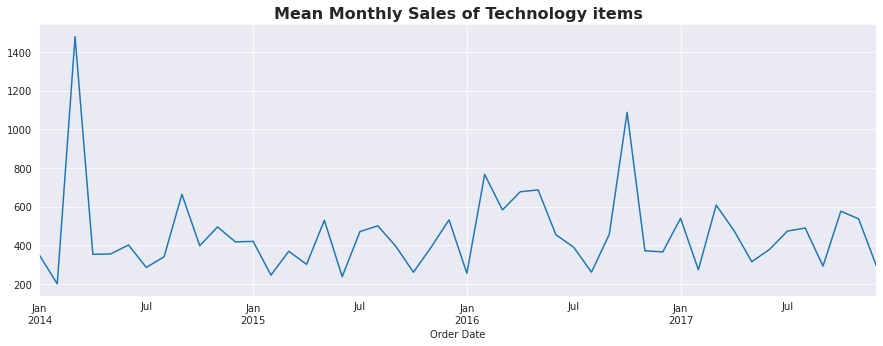

In [35]:
y_technology.plot(figsize = (15,5))
plt.title('Mean Monthly Sales of Technology items', fontsize=16, fontweight='bold')
plt.show()

Technology items have highest sales in march 2014 and also in oct-nov of 2016.

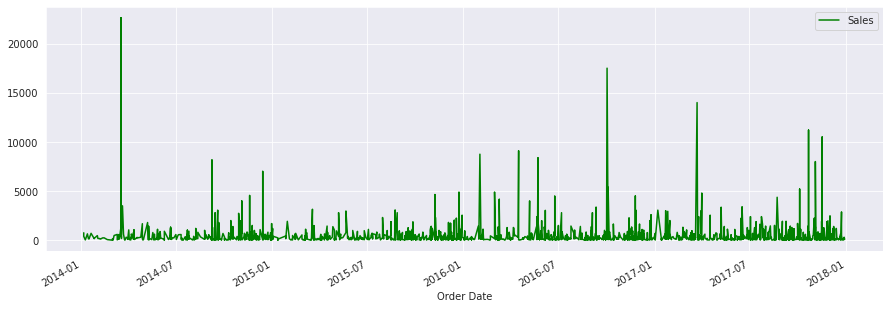

In [36]:
technology_data.plot(figsize=(15,5), c = 'green', legend = True)
plt.show()

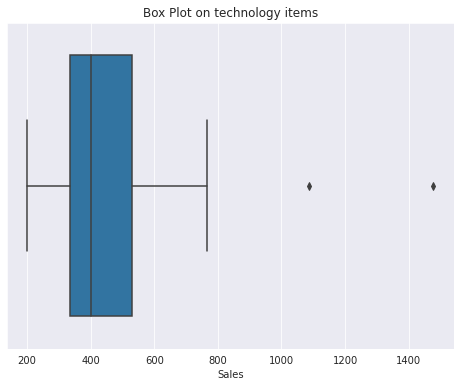

In [37]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_technology).set_title('Box Plot on technology items')
plt.show()

there are two outliers in the technology data.

## Seasonal Decomposition of each category

### Furniture items

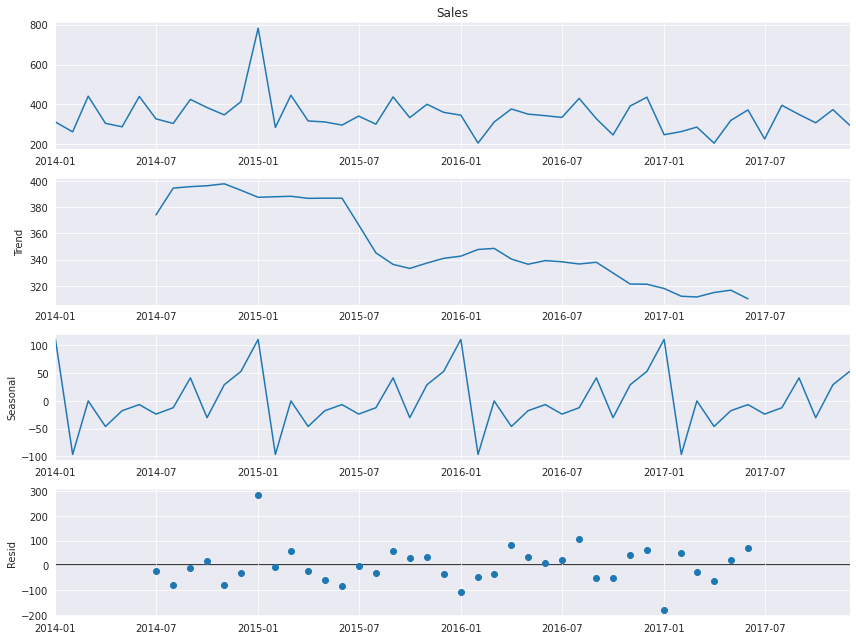

In [38]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_furniture, model='additive')
fig = decomposition.plot()
plt.show()

 - Decreasing trend is observed for the sales of furniture after 2015.

### Office items

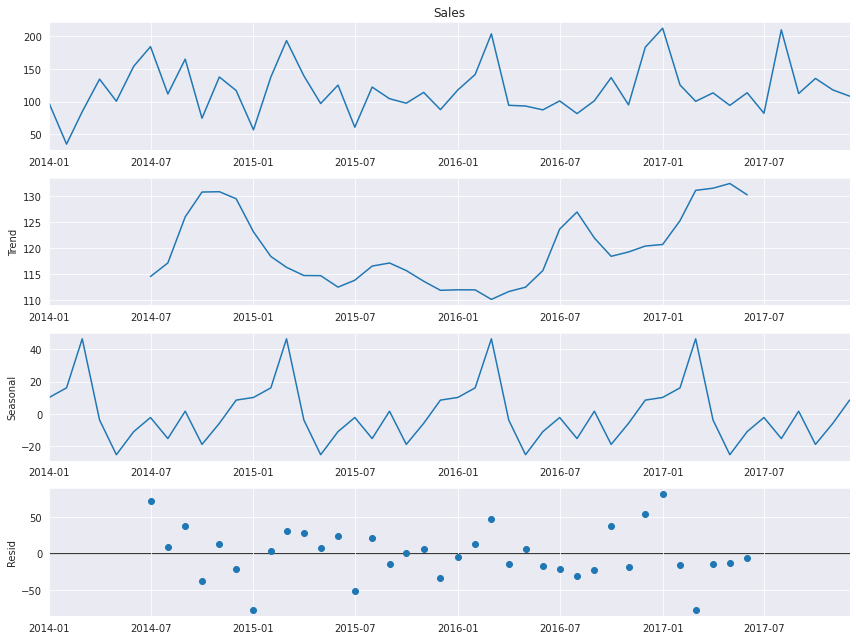

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_office, model='additive')
fig = decomposition.plot()
plt.show()

From the trend graph,there is a rise in curve and reaches a maximum at middle of 2014 after that there is huge fall in sales from 2015 to 2016. Then it gradually rises reach a maximum at beginning of 2016 and repeats.

### Technology

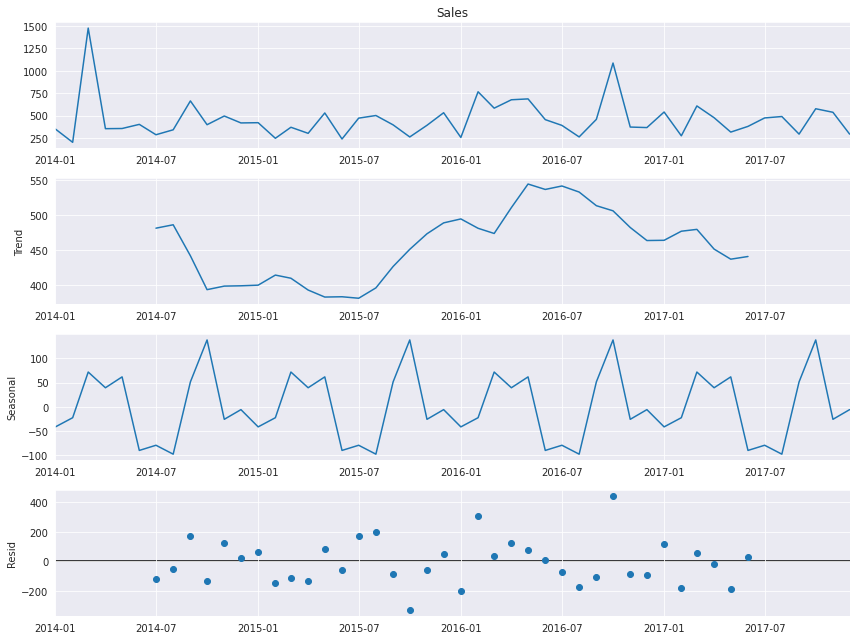

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_technology, model='additive')
fig = decomposition.plot()
plt.show()

 - Above plot shows an upward trend of sales of technology in the middle of 2016 after that it shows decreasing.


## Test for stationarity

In [41]:
#Augmented dickey-fuller test
#H0 : data is non stationary (unit root =1)
#H1 : data is stationery (unit root <1)

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF test statistic', 'p-value', 'Number of observations used', '#lags used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [42]:
adfuller_test(y_furniture)

ADF test statistic : -6.962405221214861
p-value : 9.093398510006677e-10
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [43]:
adfuller_test(y_office)

ADF test statistic : -6.100365254423857
p-value : 9.869101392257422e-08
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [44]:
adfuller_test(y_technology)

ADF test statistic : -7.8725670697716446
p-value : 4.94020681035215e-12
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


#### Findings: 
 - The p-value<0.05, so rejecting null hypothesis and assume a stationery datasets. 
 - Here the differencing value (d) is zero.

## Autocorrelation and Partial Autocorrelation plots

ACF measures correlation between the time series with a lagged version itself and PACF similiar to ACF but after eliminating the variations.

#### Furniture

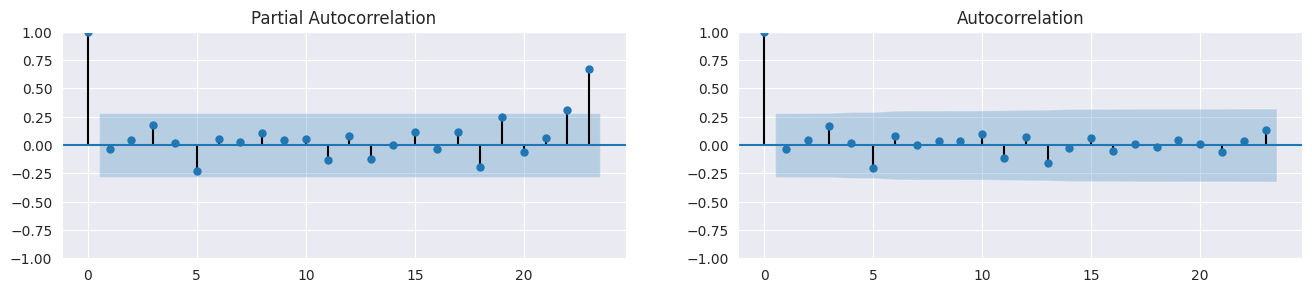

In [45]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_furniture,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_furniture, lags=23,ax=axes[1])
plt.show()

#### Office supplies

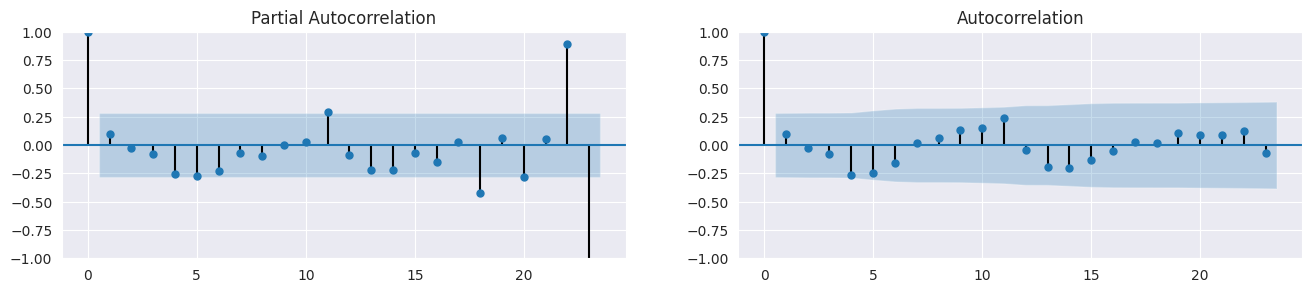

In [46]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_office,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_office, lags=23,ax=axes[1])
plt.show()

#### Technology

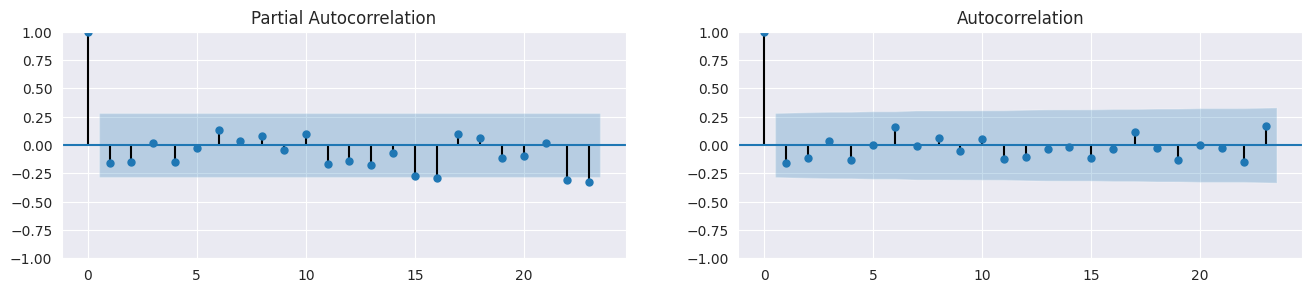

In [47]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_technology,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_technology, lags=23,ax=axes[1])
plt.show()

## Parameter selection

Parameters of the ARIMA model are defined by 
 - AR(p)-lag order
 - I(d) -degree of difference
 - MA(q) - order of moving average 
    
SARIMAX an extension of ARIMA supports time series data with a seasonal component. it is denoted by order (p,d,q)(P,D,Q)m.
 - P - Seasonal regression
 - D - differencing
 - Q - moving average coefficients
 - m - no.of datapoints in each seasonal cycle

### Furniture

In [ ]:
#splitting into test and train
train1 = y_furniture.loc['2014-01-06':'2015-12-30']
test1 = y_furniture.loc['2015-12-30':]

### approach 1: Using pyramid ARIMA for choosing best parameters

In [ ]:
model = pm.auto_arima(train1, start_p=1, start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=290.171, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=288.188, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=284.906, Time=0.05 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=286.906, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=286.906, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=282.907, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=284.907, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=284.907, Time=0.05

In [ ]:
model.fit(train1)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
model_furniture = SARIMAX(y_furniture,order=(0,1,0),seasonal_order=(1,0,0,12),enforce_invertibility=False)

In [ ]:
result_furniture = model_furniture.fit()

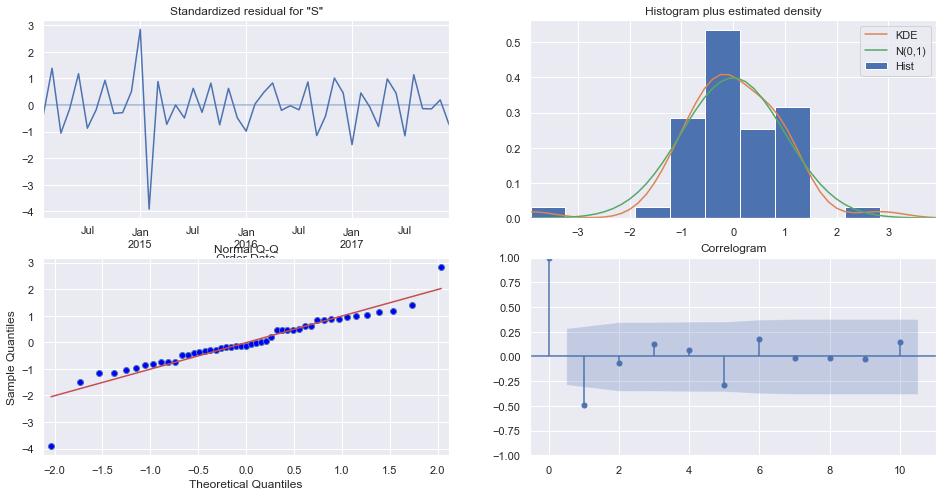

In [ ]:
result_furniture.plot_diagnostics(figsize=(16,8))
plt.show()

Residuals are normally distributed and uncorrelated.

In [ ]:
start = len(train1)
end = len(train1) + len(test1) - 1

In [ ]:
prediction_furniture = result_furniture.predict(start,end).rename('SARIMA model')
prediction_furniture

Order Date
2015-12-01    420.304818
2016-01-01    467.722113
2016-02-01    201.969929
2016-03-01    253.494784
2016-04-01    274.772325
2016-05-01    376.051853
2016-06-01    347.036610
2016-07-01    357.075504
2016-08-01    323.285751
2016-09-01    470.142164
2016-10-01    298.325824
2016-11-01    266.792834
2016-12-01    380.679102
2017-01-01    432.520227
2017-02-01    207.885528
2017-03-01    294.756032
2017-04-01    305.620455
2017-05-01    198.534542
2017-06-01    317.729284
2017-07-01    370.141248
2017-08-01    254.864084
2017-09-01    366.332195
2017-10-01    326.182439
2017-11-01    350.341761
Freq: MS, Name: SARIMA model, dtype: float64

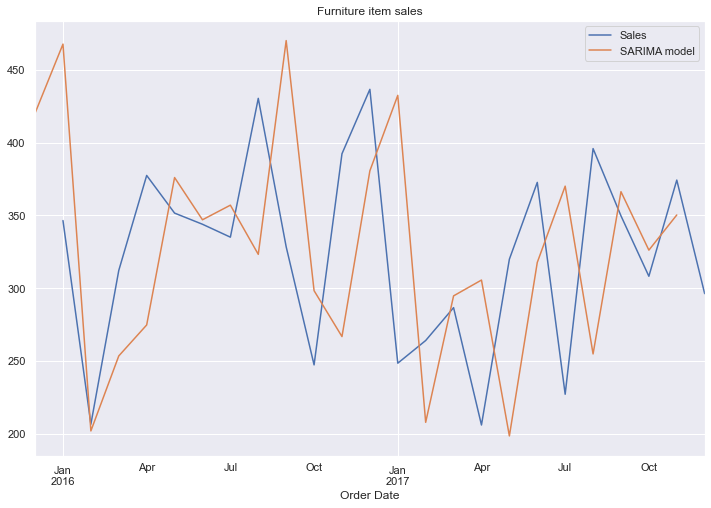

In [ ]:
test1.plot(figsize=(12,8),legend=True)
prediction_furniture.plot(legend=True)
plt.title("Furniture item sales")
plt.show()

Observed and SARIMA prediction are almost close.

#### evaluating model

In [ ]:
mean_squared_error(test1,prediction_furniture)

13247.090831966305

In [ ]:
rmse(test1,prediction_furniture)

115.09600702008

In [ ]:
test1.mean()

323.26922678404185

In [ ]:
model_furniture_ = SARIMAX(y_furniture,order=(0,1, 0),seasonal_order=(1, 0, 0, 12),enforce_invertibility=False)

In [ ]:
result_furniture_final = model_furniture_.fit()

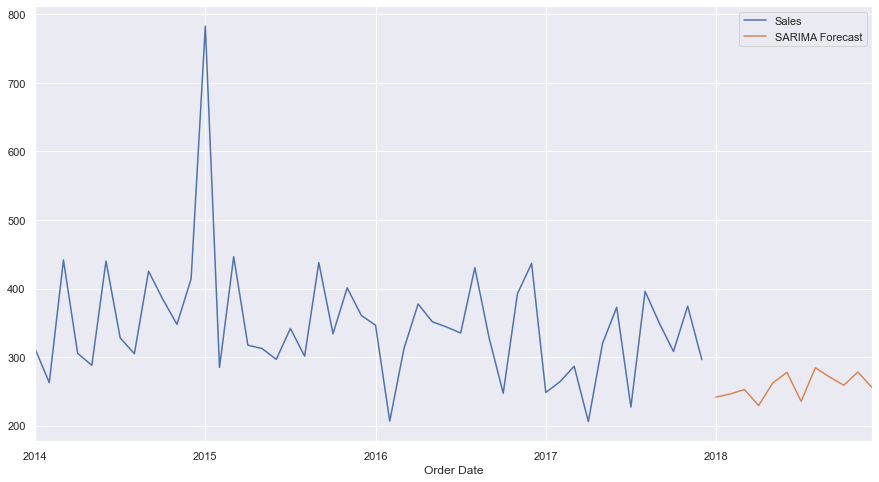

In [ ]:
forecast_furniture = result_furniture_final.predict(len(y_furniture),len(y_furniture)+11,typ='levels').rename('SARIMA Forecast')
y_furniture.plot(legend=True,figsize=(15,8))
forecast_furniture.plot(legend=True)
plt.show()

Decreasing trend is observed from forecast as from above graph.

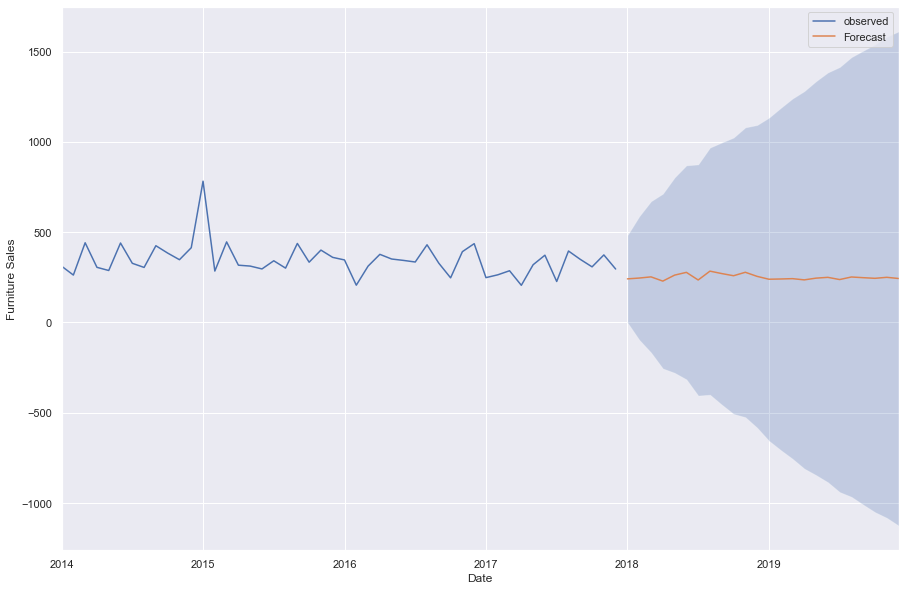

In [ ]:
pred_furniture = result_furniture_final.get_forecast(steps=24)
pred_ci_furniture = pred_furniture.conf_int()
ax = y_furniture.plot(label='observed',figsize=(15,10))
pred_furniture.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furniture.index,
               pred_ci_furniture.iloc[:,0],
               pred_ci_furniture.iloc[:,1],alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
#Forecast for next two years of furniture sales is predicted as constant.

#### approach 2: Choosing best parameters with lowest AIC score

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1565.977281468862
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.2046489859171
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:272.091984762829
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501691
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1571.0201242562
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.44645647223496
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:274.09198456327965
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680665804
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2671.215658209401
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364607
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:262.5230517047702
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1588765434245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2430.5547358352637
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662503576
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:264.5230013128144
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.638926970597
ARIMA(0, 1, 0)x(0, 0

AIC estimates relative quality of model and desired result is to find lowest possible AIC score.
The (p,d,q)(P,D,Q,m) order (0, 1, 1)(0, 1, 1, 12) have lower AIC value of 251.24.

In [ ]:
#fitting model
best_model = SARIMAX(y_furniture, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9982     13.522     -0.074      0.941     -27.502      25.505
ma.S.L12      -0.9855     13.785     -0.071      0.943     -28.004      26.033
sigma2      7620.1283   1.68e+05      0.045      0.964   -3.22e+05    3.37e+05


### Model diagnosis

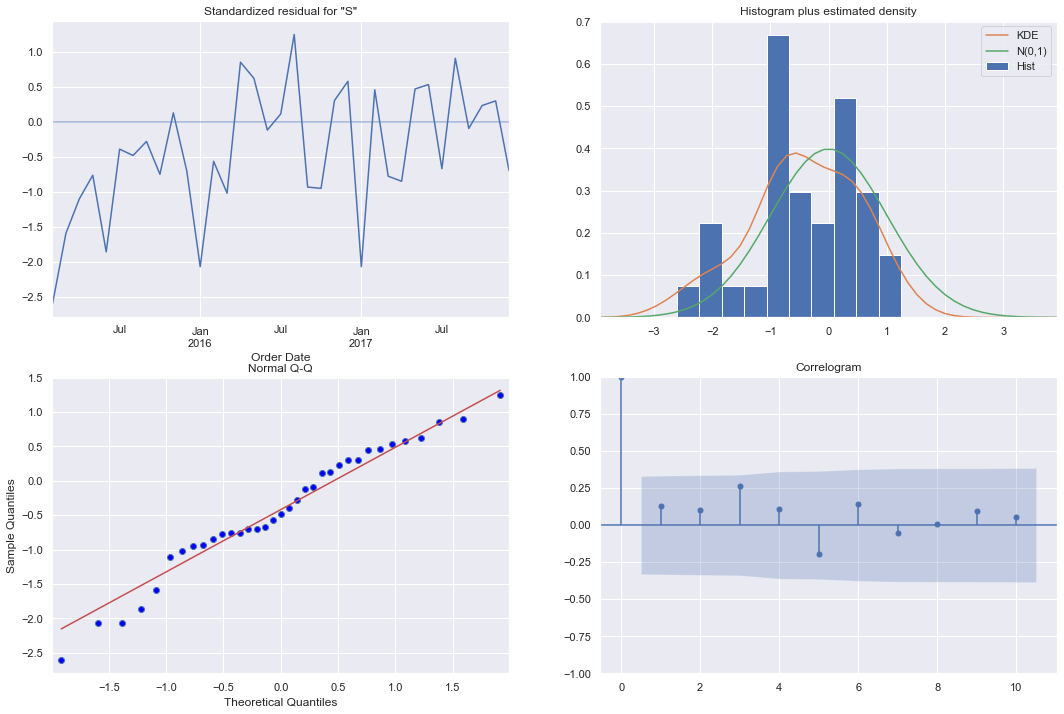

In [ ]:
best_model.plot_diagnostics(figsize=(18, 12))
plt.show()

##### Note:
From above plots,it is clear that the residuals are almost normally distributed and uncorrelated.

## Visualising Forecasts

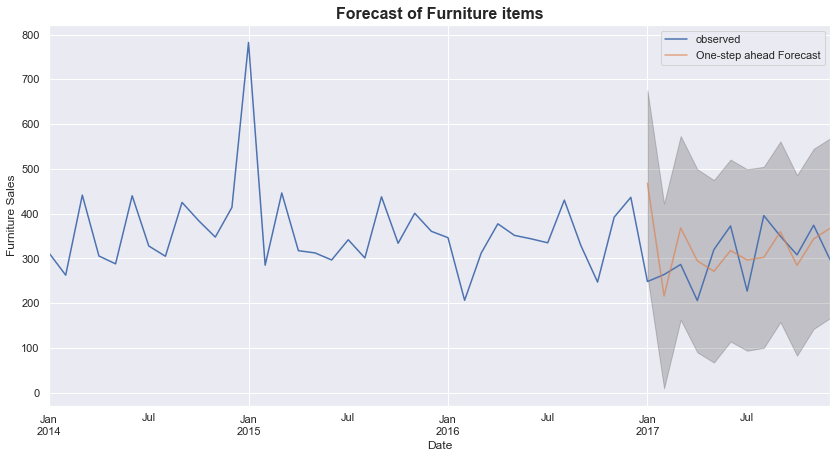

In [ ]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Forecast of Furniture items', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y_furniture['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 7554.82
The Root Mean Squared Error of our forecasts is 86.92


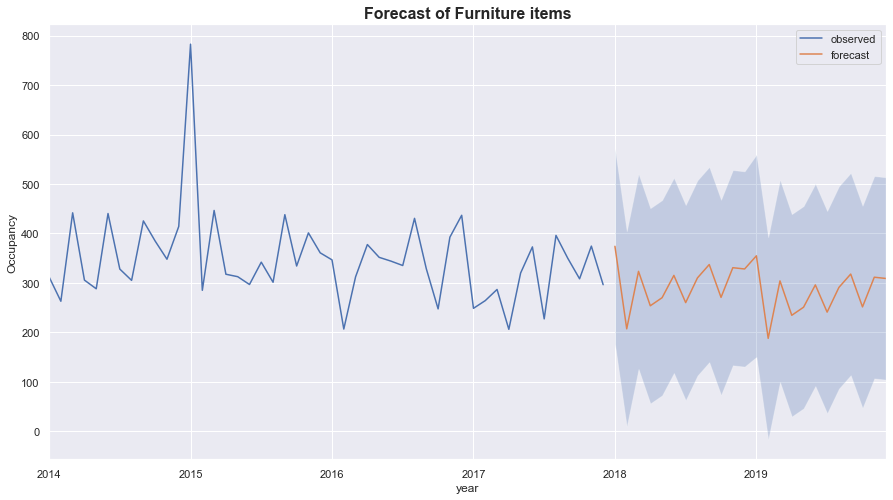

In [ ]:
# Get forecast 24 steps ahead in future
pred = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = y_furniture.plot(label='observed', figsize=(15, 8))

pred.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=0.25)
plt.title('Forecast of Furniture items', fontsize=16, fontweight='bold')
ax.set_xlabel('year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Here also Forecasts shows that the time series model is expected to slightly decreasing.

## office supplies

In [ ]:
train2 = y_office.loc['2014-01-06':'2015-12-30']
test2 = y_office.loc['2015-12-30':]

### approach 1: using pmdarima

In [ ]:
model = pm.auto_arima(train2, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=250.166, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=243.270, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=241.314, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=243.269, Time=0.03 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=245.269, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=233.576, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=234.977, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=234.686, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=231.531, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=inf, Time=

In [ ]:
model_office = SARIMAX(y_office,order=(2,2,1),seasonal_order=(0,0,0,12),enforce_invertibility=False)

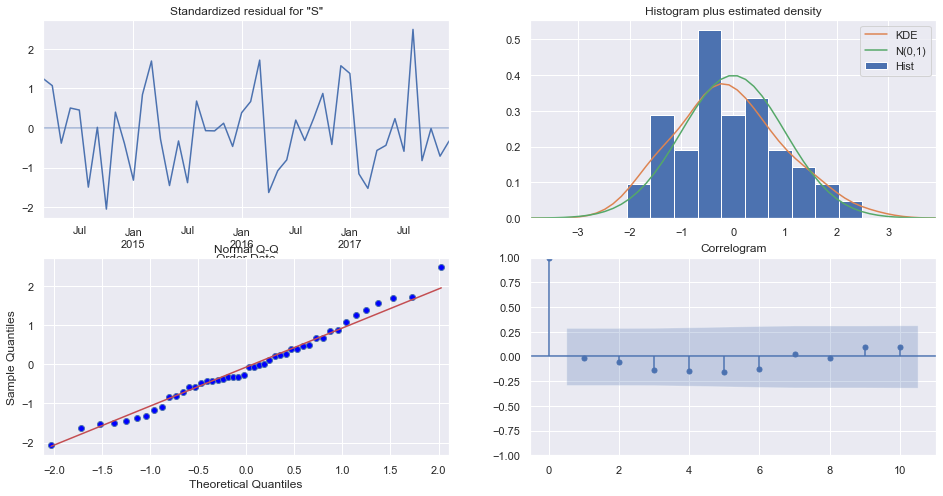

In [ ]:
result_office = model_office.fit()
result_office.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
start = len(train2)
end = len(train2) + len(test2) - 1

In [ ]:
prediction_office = result_office.predict(start,end).rename('SARIMA model')
prediction_office

Order Date
2015-12-01    109.365852
2016-01-01     99.787364
2016-02-01    110.391604
2016-03-01    124.264918
2016-04-01    170.066843
2016-05-01    143.336956
2016-06-01    124.661338
2016-07-01     91.713589
2016-08-01     96.075383
2016-09-01     89.503017
2016-10-01     96.380431
2016-11-01    114.179061
2016-12-01    110.767233
2017-01-01    148.983762
2017-02-01    179.110001
2017-03-01    170.882876
2017-04-01    139.543074
2017-05-01    114.351567
2017-06-01    102.602023
2017-07-01    109.132642
2017-08-01     95.255049
2017-09-01    150.404655
2017-10-01    136.091573
2017-11-01    150.732988
Freq: MS, Name: SARIMA model, dtype: float64

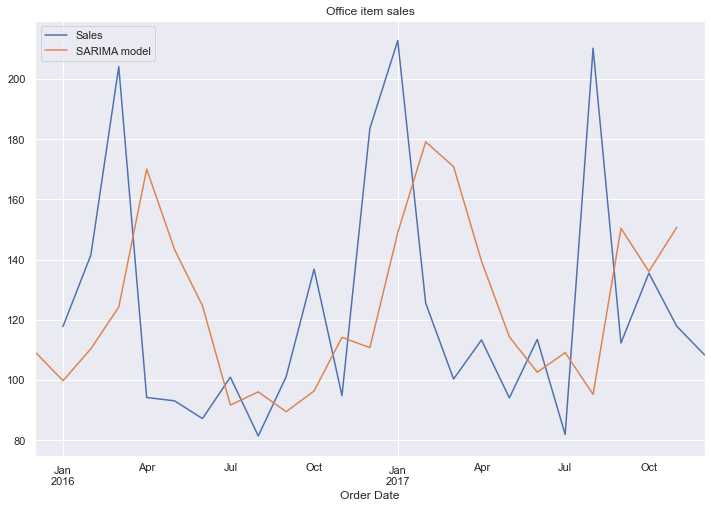

In [ ]:
test2.plot(figsize=(12,8),legend=True)
prediction_office.plot(legend=True)
plt.title("Office item sales");

In [ ]:
mean_squared_error(test2,prediction_office)

2672.2300802510385

In [ ]:
rmse(test2,prediction_office)

51.693617403418756

In [ ]:
test2.mean()

123.43622631173484

In [ ]:
model_office_final = SARIMAX(y_office,order=(2, 2, 1),seasonal_order=(0, 0, 0, 12),enforce_invertibility=False)
result_office_final = model_office_final.fit()

In [ ]:
forecast_office = result_office_final.predict(len(y_office),len(y_office)+11,typ='levels').rename('SARIMA forecast')

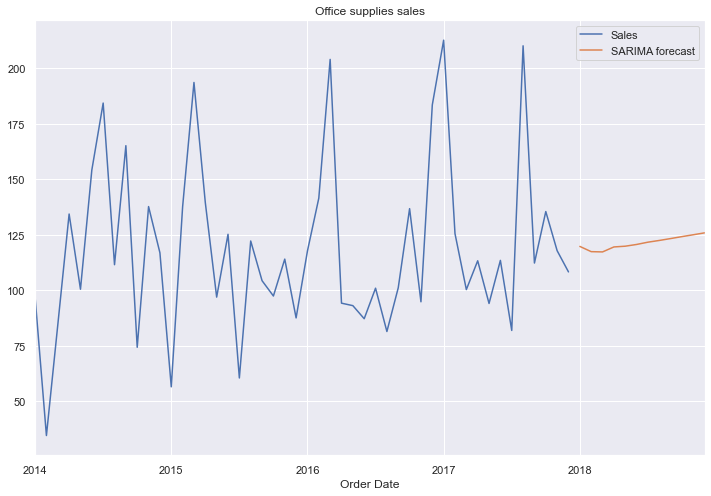

In [ ]:
y_office.plot(legend=True,figsize=(12,8))
forecast_office.plot(legend=True)
plt.title("Office supplies sales");

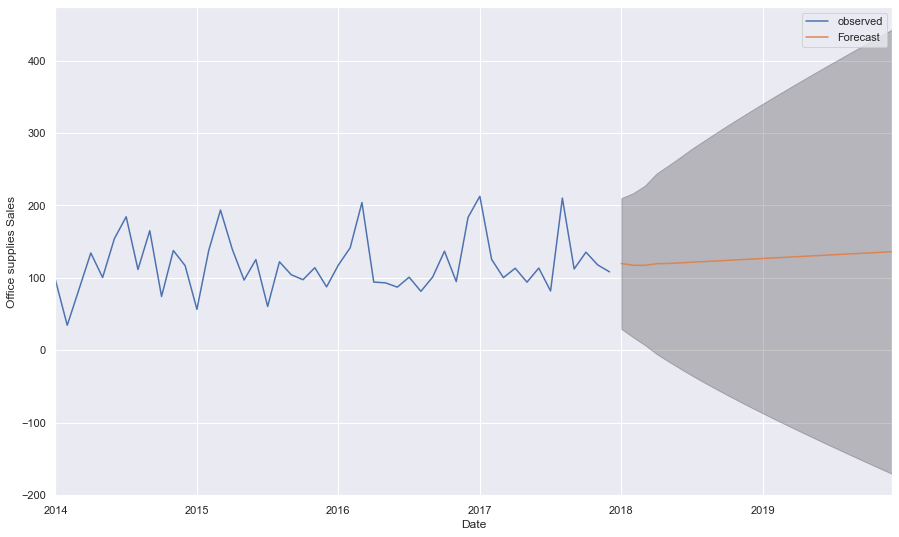

In [ ]:
pred_office = result_office_final.get_forecast(steps=24)
pred_ci_office = pred_office.conf_int()
ax = y_office.plot(label='observed',figsize=(15,9))
pred_office.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_office.index,
               pred_ci_office.iloc[:,0],
               pred_ci_office.iloc[:,1],color='k',alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office supplies Sales')
plt.legend()
plt.show()

In [ ]:
#Slightly increasing trend in sales is observed for office items.

### approach2:

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_office,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:589.5002315061224
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1347.4267897981113
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:383.41755111407554
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.8928413116318
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:394.83867919808836
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1348.9258329412073
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:260.5044719309093
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:250.10262158195803
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:545.8315751699361
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2552.5155905373776
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:371.8194830276595
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:240.39856988639355
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:396.4373424315812
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2337.8547617140594
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:262.173516381938
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:242.26144570286047
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:496.8049609774628
ARIMA(0, 1, 

ARIMA(p,d,q)(P,D,Q)m with order (0,1,1) and seasonal order (0,1,1,12) have lowest AIC score.

In [ ]:
#fitting model
best_model = SARIMAX(y_office, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9991     23.337     -0.043      0.966     -46.739      44.740
ma.S.L12      -0.5111      0.541     -0.945      0.345      -1.571       0.549
sigma2      2636.3016   6.05e+04      0.044      0.965   -1.16e+05    1.21e+05


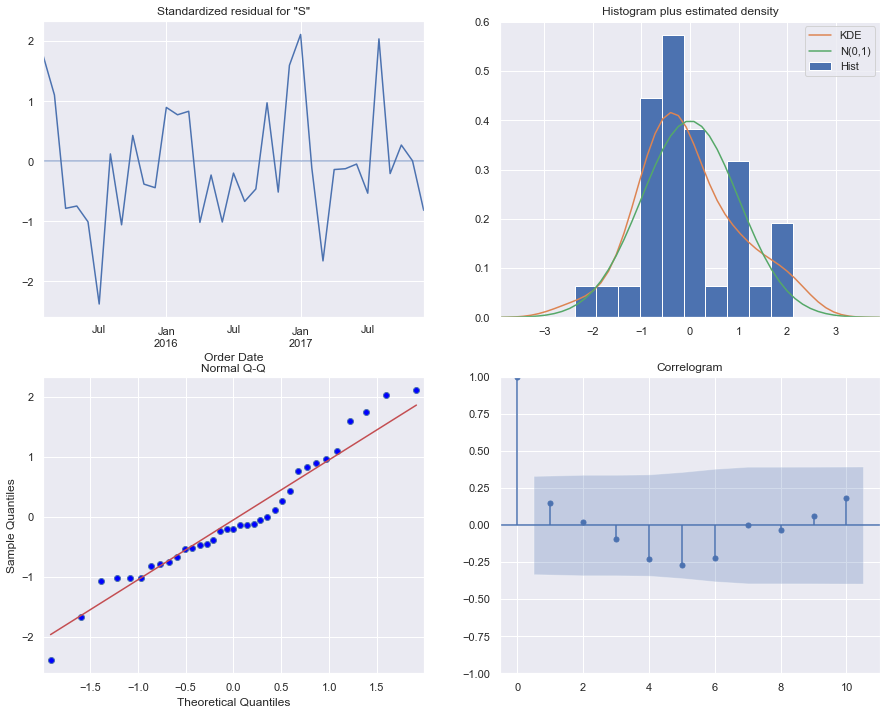

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Here residuals are near normally distributed from top right and bottom left plots and the correlation plot shows uncorrelated.

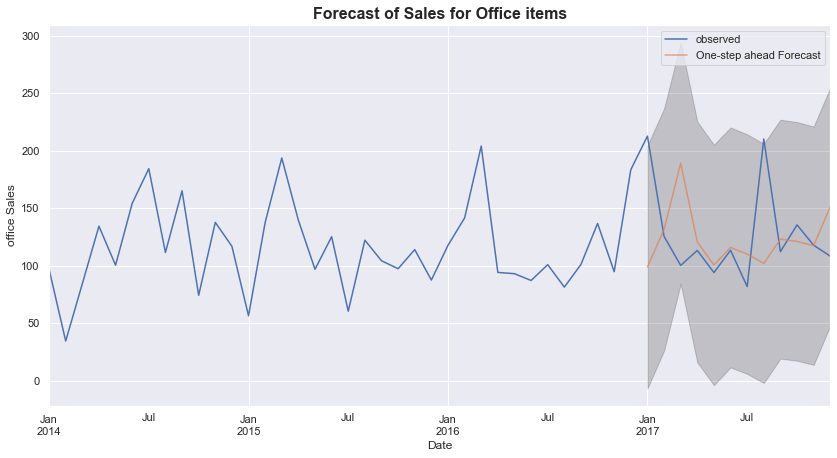

In [ ]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_office['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Forecast of Sales for Office items', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('office Sales')
plt.legend()

plt.show()


In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y_office['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2969.77
The Root Mean Squared Error of our forecasts is 54.5


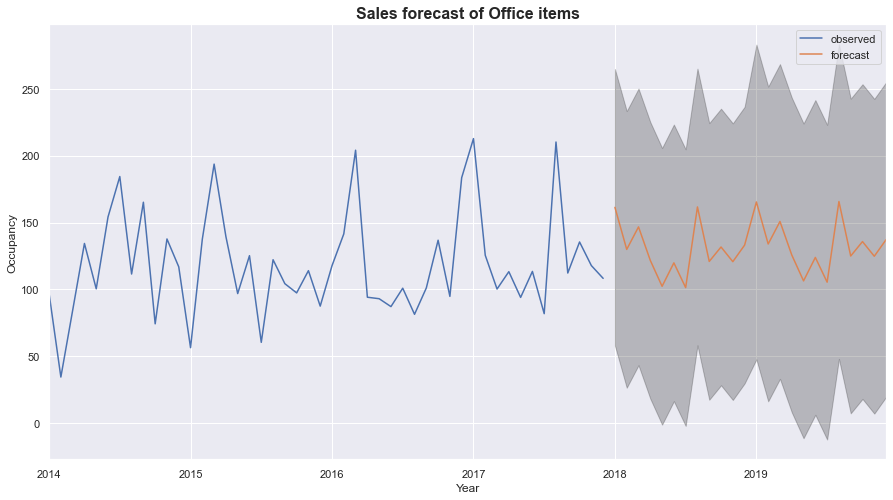

In [ ]:
# Get forecast 24 steps ahead in future
pred_uc = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_office.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Sales forecast of Office items', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Forecast and confidence intervals shows demand of office items increasing over years.

## Technology

In [ ]:
train3 = y_technology.loc['2014-01-06':'2015-12-30']
test3 = y_technology.loc['2015-12-30':]

approach 1: using pmdarima

In [ ]:
model = pm.auto_arima(train3, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=322.632, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=325.122, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=353.303, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=324.629, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=324.608, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=326.608, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=323.238, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=323.033, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=325.209, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.437 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Mod

In [ ]:
model_technology = SARIMAX(y_technology,order=(0,0,0),seasonal_order=(0,0,0,12),enforce_invertibility=False)

In [ ]:
#above indicate White noise in data so we cannot predict with white noise data 

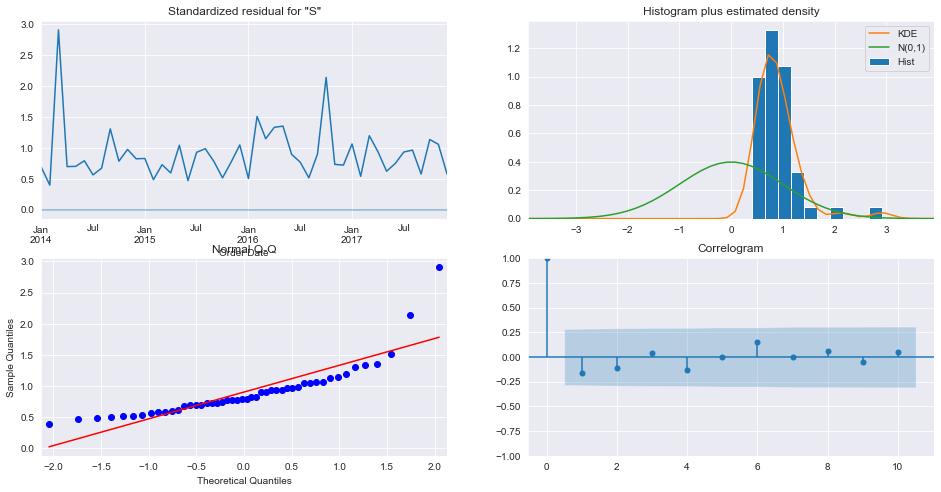

In [ ]:
result_technology = model_technology.fit()
result_technology.plot_diagnostics(figsize=(16,8))
plt.show()

It is clear that there are white noise in data so Lets try the second approach.

approach 2:

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

print('Parameter combinations for Seasonal ARIMA...')

for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_technology,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)


            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:721.5688506163442
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1487.6419240338735
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:506.0787430128274
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:322.98754525549793
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:514.1576203103061
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1493.5436371349388
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:337.72306528701387
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:324.3265655019672
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:683.3203705205927
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2654.197749724426
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:494.63999626653646
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:305.7104828501362
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:514.2823881454683
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2674.9444607170085
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:336.08723533603455
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:306.6135534234986
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:668.3045721205369
ARIMA(0, 1, 0

ARIMA(p,d,q)(P,D,Q)m with order (1,1,1) and seasonal order (1,1,1,12) have lowest AIC score.

In [ ]:
#fitting model
best_model = SARIMAX(y_technology, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2597      0.252     -1.029      0.303      -0.754       0.235
ma.L1         -0.9989     21.701     -0.046      0.963     -43.531      41.534
ar.S.L12      -0.3489      0.329     -1.062      0.288      -0.993       0.295
ma.S.L12      -0.6468      0.793     -0.816      0.415      -2.201       0.907
sigma2      5.386e+04   1.16e+06      0.046      0.963   -2.22e+06    2.33e+06


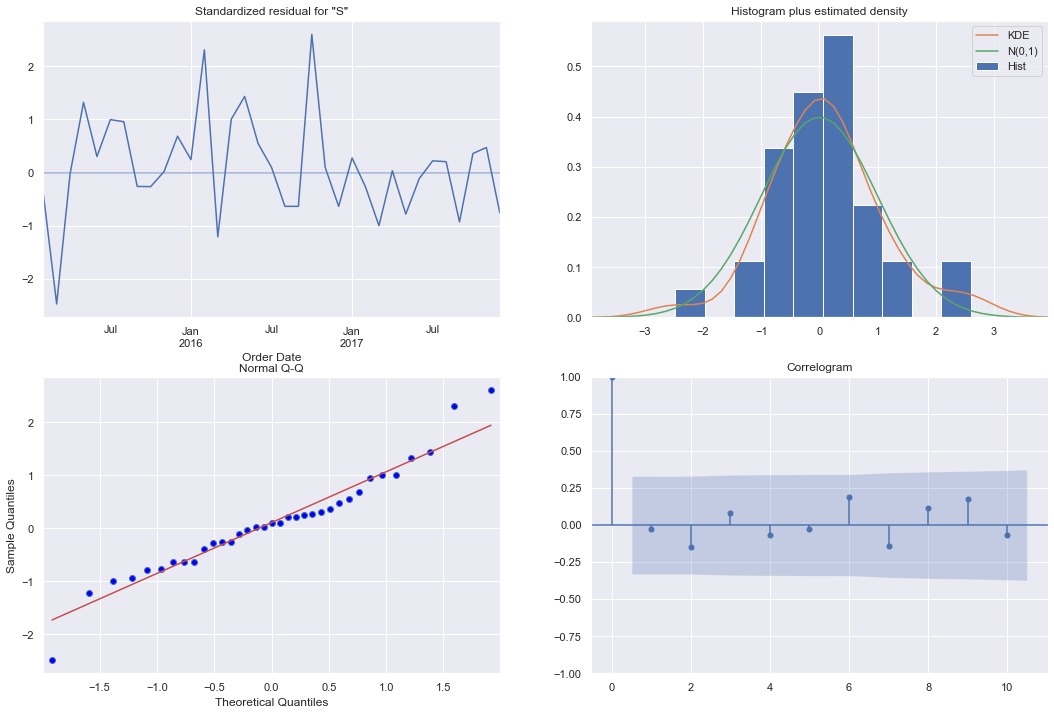

In [ ]:
best_model.plot_diagnostics(figsize=(18, 12))
plt.show()

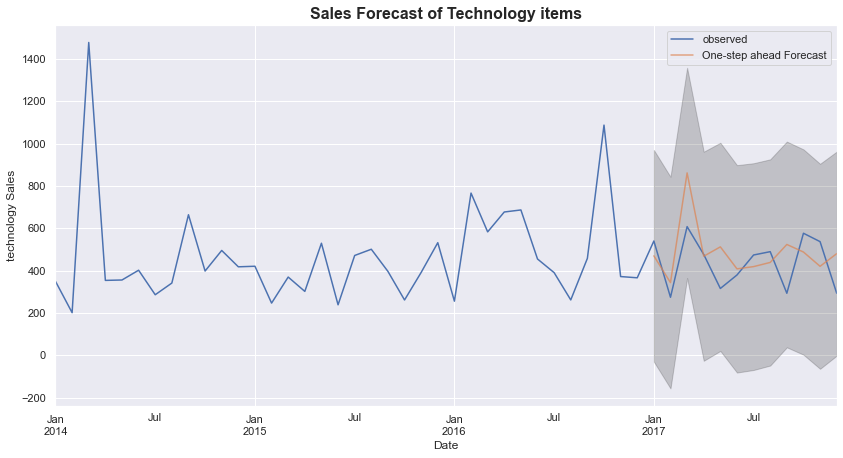

In [ ]:
pred = best_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_technology['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Sales Forecast of Technology items', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('technology Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y_technology['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 19070.01
The Root Mean Squared Error of our forecasts is 138.09


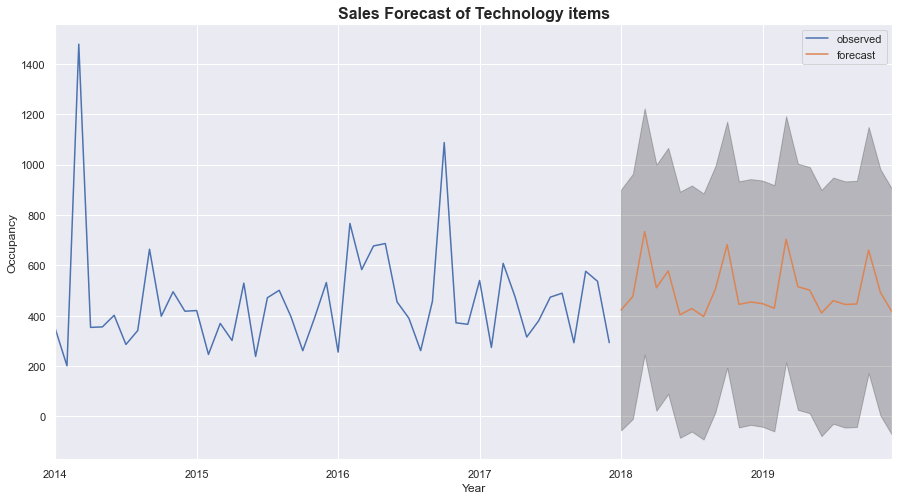

In [ ]:
# Get forecast 24 steps ahead in future
pred_uc = best_model.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_technology.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Sales Forecast of Technology items', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Somewhat constant trend in sales for technology items is observed.

### Comparing categories

In [ ]:
furniture_data.shape, office_supplies_data.shape, technology_data.shape

((2121, 1), (6026, 1), (1847, 1))

In [ ]:
#furniture_data.drop(col, axis=1, inplace=True)
#office_supplies_data.drop(col, axis=1, inplace=True)
#technology_data(col, axis=1, inplace=True)

In [ ]:
furniture_data = furniture_data.sort_values('Order Date')
office_supplies_data = office_supplies_data.sort_values('Order Date')
technology_data = technology_data.sort_values('Order Date')

furniture_data = furniture_data.groupby('Order Date')['Sales'].sum().reset_index()
office_supplies_data= office_supplies_data.groupby('Order Date')['Sales'].sum().reset_index()
technology_data = technology_data.groupby('Order Date')['Sales'].sum().reset_index()

furniture_data = furniture_data.set_index('Order Date')
office_supplies_data = office_supplies_data.set_index('Order Date')
technology_data = technology_data.set_index('Order Date')

y_furniture = furniture_data['Sales'].resample('MS').mean()
y_office = office_supplies_data['Sales'].resample('MS').mean()
y_technology = technology_data['Sales'].resample('MS').mean()

In [ ]:
furniture = pd.DataFrame({'Order Date': y_furniture.index , 'Sales':y_furniture.values})
furniture.head()

,Order Date,Sales
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


In [ ]:
office = pd.DataFrame({'Order Date': y_office.index , 'Sales':y_office.values})
office.head()

,Order Date,Sales
0,2014-01-01,285.357647
1,2014-02-01,63.042588
2,2014-03-01,391.176318
3,2014-04-01,464.794750
4,2014-05-01,324.346545


In [ ]:
technology = pd.DataFrame({'Order Date': y_technology.index , 'Sales':y_technology.values})
technology.head()

,Order Date,Sales
0,2014-01-01,449.041429
1,2014-02-01,229.787143
2,2014-03-01,2031.948375
3,2014-04-01,613.028933
4,2014-05-01,564.698588


In [ ]:
store = pd.merge(furniture,office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales', 'Sales_z': 'technology_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [ ]:
store_office_furniture_technology = technology.merge(store, how='inner', on='Order Date')
store_office_furniture_technology.rename(columns={'Sales': 'technology_sales', 'Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)
store_office_furniture_technology

,Order Date,technology_sales,furniture_sales,office_sales
0,2014-01-01,449.041429,480.194231,285.357647
1,2014-02-01,229.787143,367.931600,63.042588
2,2014-03-01,2031.948375,857.291529,391.176318
3,2014-04-01,613.028933,567.488357,464.794750
4,2014-05-01,564.698588,432.049188,324.346545
5,2014-06-01,766.905909,695.059242,588.774409
6,2014-07-01,533.608933,601.169500,756.060400
7,2014-08-01,708.435385,457.521656,541.879143
8,2014-09-01,2035.838133,992.353367,1015.677704
9,2014-10-01,596.900900,769.015437,267.078815


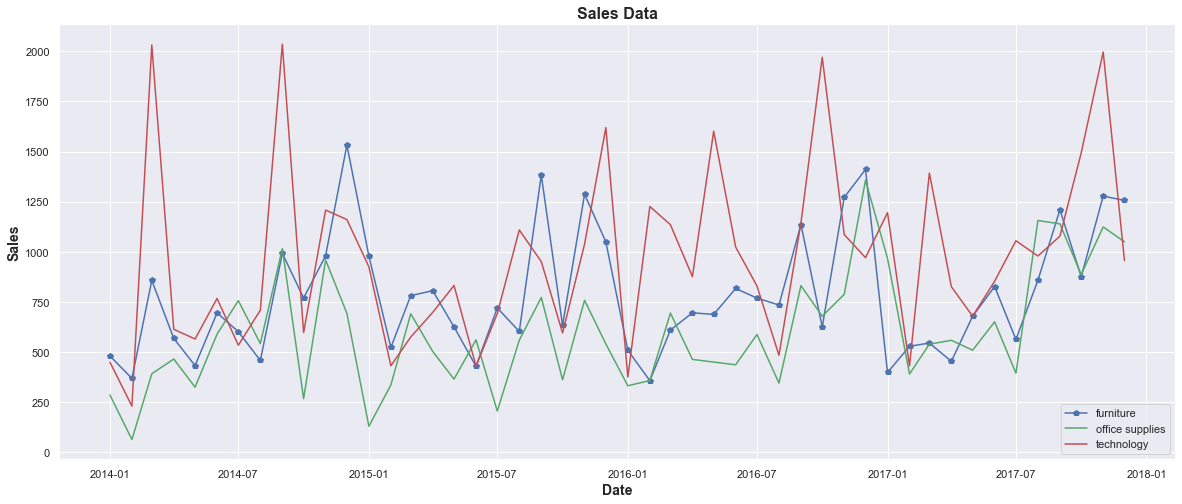

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(20,8))
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['furniture_sales'],'p-',label='furniture')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['office_sales'],'g-',label='office supplies')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales Data', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

#### Findings:
- from above plot, it is clear that technology items are most selling item compare to other categories and sales of office supplies is least.
        
- sales of technology items is more than 2000 in the year 2014 but after that sales is declining in 2015.
    
- Sales of furniture items shows a maximum at the end of year 2014 and a similiar rise occurs in second half of 2015 and 2016.
        
- office supplies has maximum sales at the end of 2016.

### comparing sales of different categories

### a) Furniture vs office items

In [ ]:
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


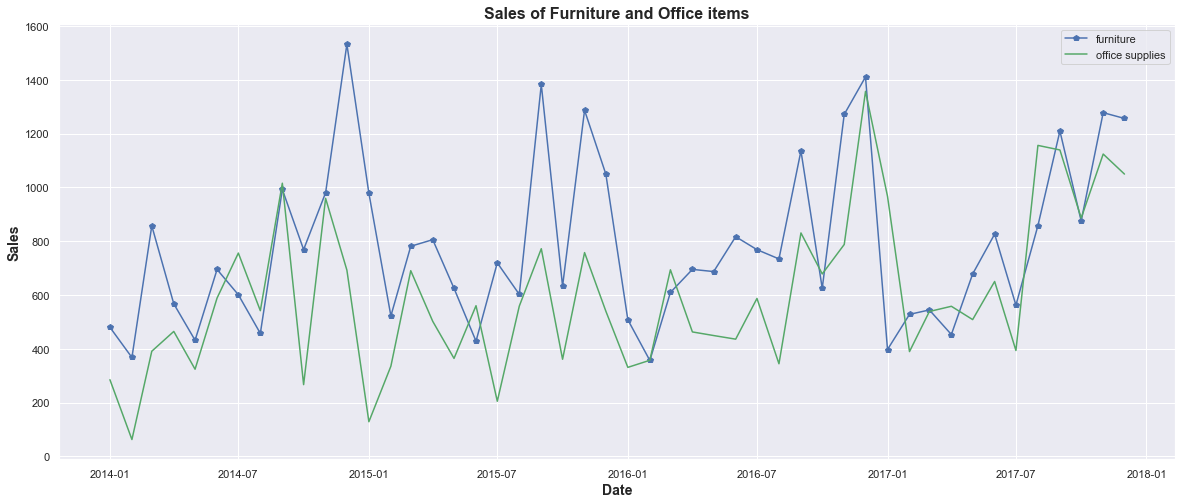

In [ ]:
plt.figure(figsize=(20,8))

plt.plot(store['Order Date'],store['furniture_sales'],'p-',label='furniture')
plt.plot(store['Order Date'],store['office_sales'],'g-',label='office supplies')

plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Office items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

 - sales of both product categories is increasing over years.
 - for office supplies, it shows high sales during the month of september 2016 and furniture items have also similiar sales at that time.
 -  Furniture items have high sales during september 2014 and lower sales during march of 2014 and 2016 while Office items have lower sales during march 2014.
 - Sales of both categories are high during second half of year.

### b) Furniture vs Technology items sales

In [ ]:
store_furniture_technology = pd.merge(furniture,technology, how='inner', on='Order Date')
store_furniture_technology.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_furniture_technology.head()

,Order Date,furniture_sales,technology_sales
0,2014-01-01,480.194231,449.041429
1,2014-02-01,367.931600,229.787143
2,2014-03-01,857.291529,2031.948375
3,2014-04-01,567.488357,613.028933
4,2014-05-01,432.049188,564.698588


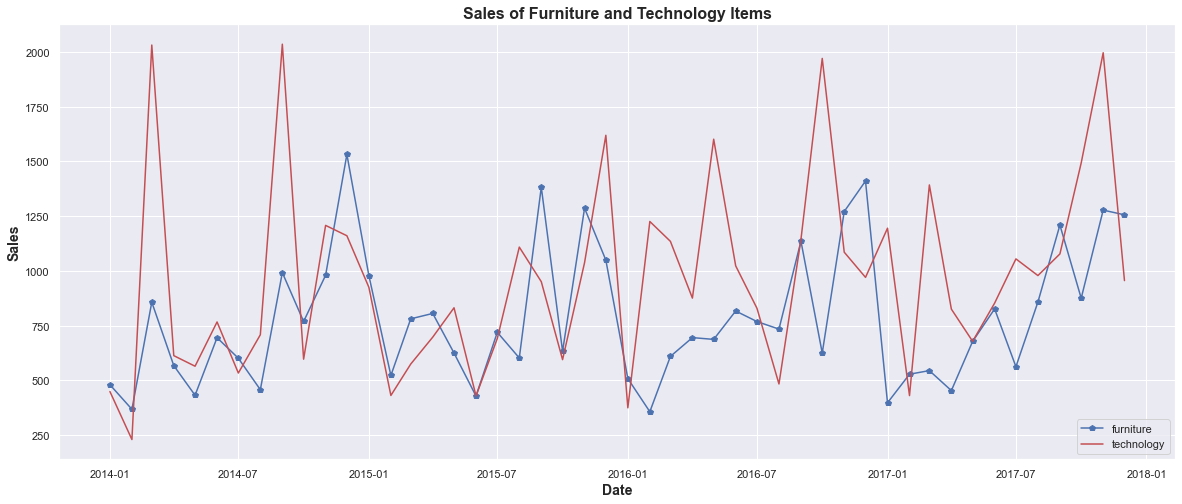

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['furniture_sales'],'p-',label='furniture')
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

From above plot it is clear that technology items has more demand than furniture items.
 - higher sales for technology is observed on month of march,september in 2014, secondly in october of 2017.
 - higher sales for furniture was observed at the end of 2014 (december).
 - Both of them have lower sales during the start of 2014 probably on month of february.

### c) office items vs technology sales

In [ ]:
store_office_technology = pd.merge(office,technology, how='inner', on='Order Date')
store_office_technology.rename(columns={'Sales_x': 'office_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_office_technology.head()

,Order Date,office_sales,technology_sales
0,2014-01-01,285.357647,449.041429
1,2014-02-01,63.042588,229.787143
2,2014-03-01,391.176318,2031.948375
3,2014-04-01,464.794750,613.028933
4,2014-05-01,324.346545,564.698588


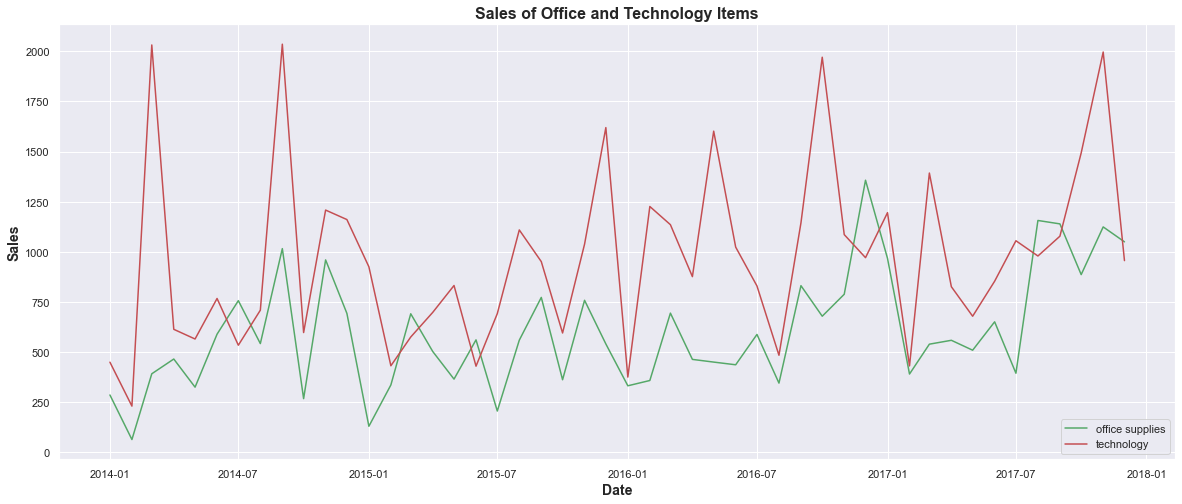

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(store_office_technology ['Order Date'],store_office_technology ['office_sales'],'g-',label='office supplies')
plt.plot(store_office_technology ['Order Date'],store_office_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Office and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

Increasing trend is observed for both categories from 2014 to 2018.
Here also technology items have higher sales than office supplies which makes it highly demandable product. Higher sales of furniture was observed on september of 2016.

#### Findings:
 - Technology items is the highest selling product category.
 - Office items is least selling category in the superstore.


### **Furniture**

In [48]:
y_furniture_df = y_furniture.to_frame()
y_furniture_df['ds'] = y_furniture_df.index
y_furniture_df.columns = ['y','ds']
y_furniture_df

,y,ds
Order Date,,
2014-01-01,312.126250,2014-01-01
2014-02-01,262.808286,2014-02-01
2014-03-01,441.635030,2014-03-01
2014-04-01,305.570654,2014-04-01
2014-05-01,288.032792,2014-05-01
2014-06-01,440.204187,2014-06-01
2014-07-01,327.910636,2014-07-01
2014-08-01,305.014437,2014-08-01
2014-09-01,425.294300,2014-09-01


In [49]:
m_furniture = Prophet()

m_furniture.fit(y_furniture_df)

future_furniture = m_furniture.make_future_dataframe(periods=24,freq='MS')

future_furniture

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [50]:
forecast_furniture = m_furniture.predict(future_furniture)
forecast_furniture


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,373.336991,343.137837,508.647452,373.336991,373.336991,51.668979,51.668979,51.668979,51.668979,51.668979,51.668979,0.0,0.0,0.0,425.005970
1,2014-02-01,371.644629,220.365500,387.696489,371.644629,371.644629,-69.318286,-69.318286,-69.318286,-69.318286,-69.318286,-69.318286,0.0,0.0,0.0,302.326343
2,2014-03-01,370.116044,333.966152,501.811038,370.116044,370.116044,49.698764,49.698764,49.698764,49.698764,49.698764,49.698764,0.0,0.0,0.0,419.814808
3,2014-04-01,368.423682,243.574305,405.237432,368.423682,368.423682,-44.085168,-44.085168,-44.085168,-44.085168,-44.085168,-44.085168,0.0,0.0,0.0,324.338514
4,2014-05-01,366.785912,260.363414,422.604039,366.785912,366.785912,-24.972627,-24.972627,-24.972627,-24.972627,-24.972627,-24.972627,0.0,0.0,0.0,341.813286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,262.075324,145.352232,304.670017,262.075194,262.075457,-40.014025,-40.014025,-40.014025,-40.014025,-40.014025,-40.014025,0.0,0.0,0.0,222.061299
68,2019-09-01,260.382915,292.740408,451.999734,260.382775,260.383060,110.245874,110.245874,110.245874,110.245874,110.245874,110.245874,0.0,0.0,0.0,370.628789
69,2019-10-01,258.745101,189.880027,356.864989,258.744954,258.745254,19.677497,19.677497,19.677497,19.677497,19.677497,19.677497,0.0,0.0,0.0,278.422597
70,2019-11-01,257.052692,183.722861,364.840400,257.052536,257.052856,17.364978,17.364978,17.364978,17.364978,17.364978,17.364978,0.0,0.0,0.0,274.417670


In [51]:
forecast_furniture.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [52]:
forecast_furniture[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,295.963130,467.536070,379.816529
61,2019-02-01,89.885939,243.239406,167.074086
62,2019-03-01,277.424532,444.468397,356.570640
63,2019-04-01,134.771336,291.807455,209.222683
64,2019-05-01,147.565626,311.394297,230.231241
65,2019-06-01,209.059853,374.962519,294.458097
66,2019-07-01,184.115398,345.979272,268.191088
67,2019-08-01,145.352232,304.670017,222.061299
68,2019-09-01,292.740408,451.999734,370.628789
69,2019-10-01,189.880027,356.864989,278.422597


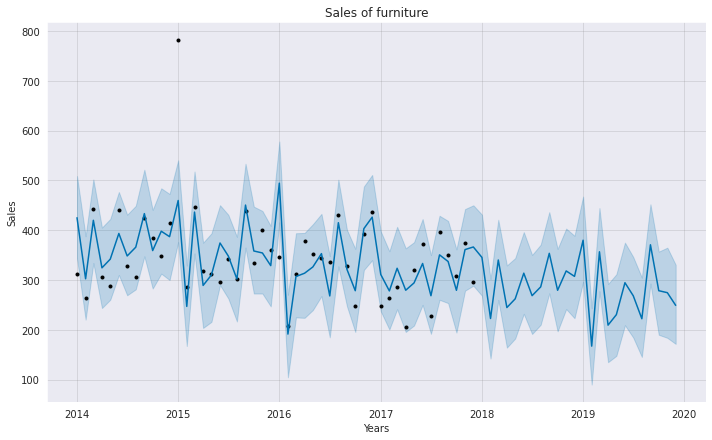

In [53]:
m_furniture.plot(forecast_furniture);
plt.title('Sales of furniture')
plt.xlabel('Years')
plt.ylabel('Sales');

Above plot is forecasting of furniture items sales for the next two years and it shows decreasing trend in sales for the upcoming years.


*   High sales is predicted on December of 2018 and August, september in 2019.
*   Low sales is expected at the beginning of year around February for both categories.
*   Compared to 2018, 2019 have lower sales of furniture in the month of december and high sales in March than in 2018.





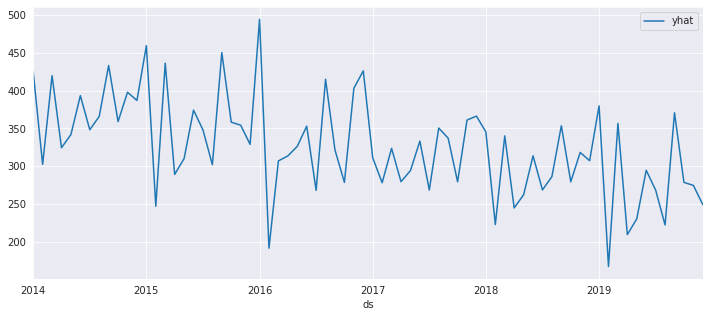

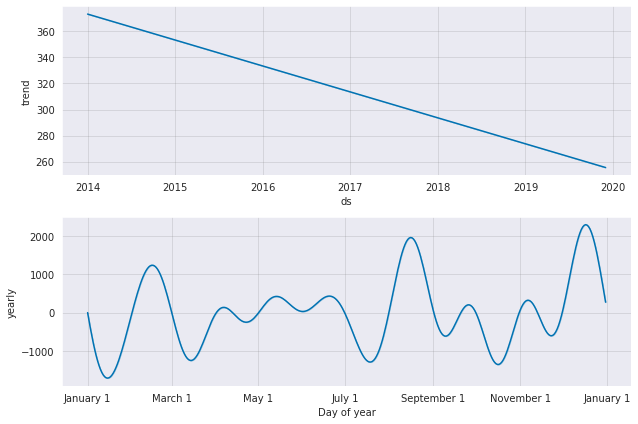

In [54]:
plot_plotly(m_furniture, forecast_furniture)
forecast_furniture.plot(x='ds',y='yhat',figsize=(12,5))

m_furniture.plot_components(forecast_furniture);

#### **Note:**
* The trend plot shows linearly decreasing demand of furniture items from 2014 to 2020.
* From the yearly seasonality plot, it is clear that high seasonality occur in the month of november and December.
* low seasonality is seen middle of January and in february. 


In [55]:
plot_components_plotly(m_furniture , forecast_furniture)


#### **Note:**
* Higher seasonality on December 16, August 16 is predicted from the plot.
* Lower seasonality predicted on January 15, March 16, July 19.

### **Office supplies**

In [56]:
y_office_df = y_office.to_frame()
y_office_df['ds'] = y_office_df.index
y_office_df.columns = ['y','ds']
y_office_df

,y,ds
Order Date,,
2014-01-01,97.021600,2014-01-01
2014-02-01,34.571742,2014-02-01
2014-03-01,84.371363,2014-03-01
2014-04-01,134.398482,2014-04-01
2014-05-01,100.501746,2014-05-01
2014-06-01,154.202821,2014-06-01
2014-07-01,184.404976,2014-07-01
2014-08-01,111.563353,2014-08-01
2014-09-01,165.200590,2014-09-01


In [57]:
m_office = Prophet()

m_office.fit(y_office_df)

future_office = m_office.make_future_dataframe(periods=24,freq='MS')

future_office

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [58]:
forecast_office = m_office.predict(future_office)
forecast_office

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,124.087349,80.124214,168.098359,124.087349,124.087349,1.828976,1.828976,1.828976,1.828976,1.828976,1.828976,0.0,0.0,0.0,125.916325
1,2014-02-01,124.426406,49.490256,134.922421,124.426406,124.426406,-30.907729,-30.907729,-30.907729,-30.907729,-30.907729,-30.907729,0.0,0.0,0.0,93.518677
2,2014-03-01,124.732651,94.111005,178.887297,124.732651,124.732651,12.507996,12.507996,12.507996,12.507996,12.507996,12.507996,0.0,0.0,0.0,137.240647
3,2014-04-01,125.071708,75.765146,165.273296,125.071708,125.071708,-6.111976,-6.111976,-6.111976,-6.111976,-6.111976,-6.111976,0.0,0.0,0.0,118.959732
4,2014-05-01,125.399828,43.587649,127.626587,125.399828,125.399828,-39.530064,-39.530064,-39.530064,-39.530064,-39.530064,-39.530064,0.0,0.0,0.0,85.869764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,146.377616,101.874181,186.448230,146.377613,146.377619,-1.339291,-1.339291,-1.339291,-1.339291,-1.339291,-1.339291,0.0,0.0,0.0,145.038324
68,2019-09-01,146.716673,106.772038,192.203550,146.716670,146.716676,2.462828,2.462828,2.462828,2.462828,2.462828,2.462828,0.0,0.0,0.0,149.179501
69,2019-10-01,147.044793,69.475555,155.457309,147.044789,147.044796,-34.577497,-34.577497,-34.577497,-34.577497,-34.577497,-34.577497,0.0,0.0,0.0,112.467296
70,2019-11-01,147.383850,118.949020,205.291524,147.383846,147.383853,14.527130,14.527130,14.527130,14.527130,14.527130,14.527130,0.0,0.0,0.0,161.910980


In [59]:
forecast_office.columns

forecast_office[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,81.139409,162.795999,123.768560
61,2019-02-01,91.943230,178.089446,133.898871
62,2019-03-01,110.196042,195.414197,152.051694
63,2019-04-01,103.958626,191.716470,147.722553
64,2019-05-01,55.739536,139.824396,97.024224
65,2019-06-01,98.902710,183.357452,140.851714
66,2019-07-01,64.014439,147.895837,106.157384
67,2019-08-01,101.874181,186.448230,145.038324
68,2019-09-01,106.772038,192.203550,149.179501
69,2019-10-01,69.475555,155.457309,112.467296


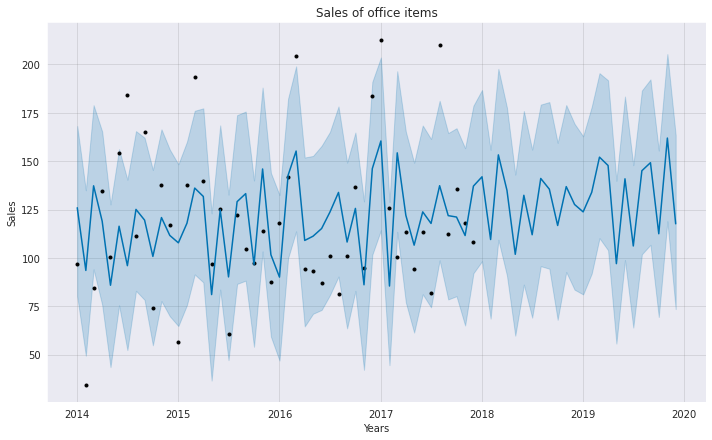

In [61]:
m_office.plot(forecast_office)
plt.title('Sales of office items')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()

#### **Note:**
* Above plot shows increasing sales of office items for the next two years.
* Higher sales predicted at the end of year probably in the months of September, November, December in 2019. In 2018 higher sales predicted on march.
* In both 2018 and 2019, lower Sales are expected on month of may.

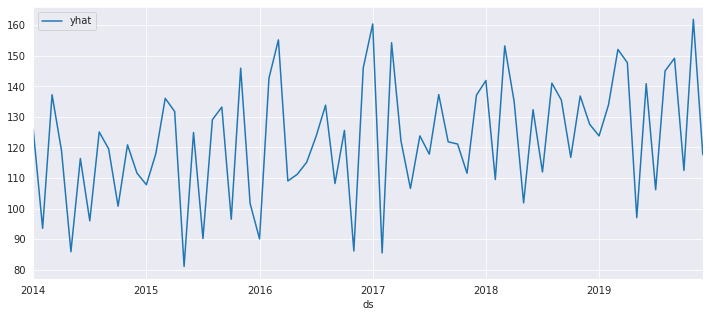

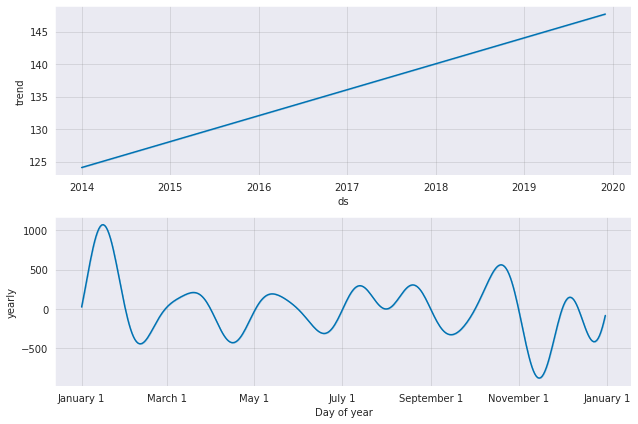

In [62]:
plot_plotly(m_office, forecast_office)
forecast_office.plot(x='ds',y='yhat',figsize=(12,5))

m_office.plot_components(forecast_office);

#### **Note:**
* From trend plot, a linearly increasing trend is observed for the sales of office items, which indicates increasing demand of office items for the next few years.
* Higher seasonality is observed on mid of january and lower seasonality on Mid of November.

In [63]:
plot_components_plotly(m_office, forecast_office)

Higher seasonality on January 16 and lowest on November 15 is predicted.

### **Technology**

In [64]:
y_technology_df = y_technology.to_frame()
y_technology_df['ds'] = y_technology_df.index
y_technology_df.columns = ['y','ds']
y_technology_df

,y,ds
Order Date,,
2014-01-01,349.254444,2014-01-01
2014-02-01,201.063750,2014-02-01
2014-03-01,1477.780636,2014-03-01
2014-04-01,353.670538,2014-04-01
2014-05-01,355.550963,2014-05-01
2014-06-01,401.712619,2014-06-01
2014-07-01,285.861929,2014-07-01
2014-08-01,341.098519,2014-08-01
2014-09-01,663.860261,2014-09-01


In [65]:
m_technology = Prophet()

m_technology.fit(y_technology_df)

future_technology = m_technology.make_future_dataframe(periods=24,freq='MS')

future_technology

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2014-01-01
1,2014-02-01
2,2014-03-01
3,2014-04-01
4,2014-05-01
...,...
67,2019-08-01
68,2019-09-01
69,2019-10-01
70,2019-11-01


In [66]:
forecast_technology = m_technology.predict(future_technology)
forecast_technology

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,517.377386,248.754069,625.992375,517.377386,517.377386,-83.408454,-83.408454,-83.408454,-83.408454,-83.408454,-83.408454,0.0,0.0,0.0,433.968932
1,2014-02-01,517.341761,106.600302,508.241387,517.341761,517.341761,-215.203754,-215.203754,-215.203754,-215.203754,-215.203754,-215.203754,0.0,0.0,0.0,302.138007
2,2014-03-01,517.309583,565.327468,971.360239,517.309583,517.309583,251.687443,251.687443,251.687443,251.687443,251.687443,251.687443,0.0,0.0,0.0,768.997026
3,2014-04-01,517.273958,192.117112,583.235661,517.273958,517.273958,-125.102798,-125.102798,-125.102798,-125.102798,-125.102798,-125.102798,0.0,0.0,0.0,392.171160
4,2014-05-01,517.239482,261.461718,662.203130,517.239482,517.239482,-57.018122,-57.018122,-57.018122,-57.018122,-57.018122,-57.018122,0.0,0.0,0.0,460.221360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-08-01,515.035312,355.129403,743.187420,515.035292,515.035331,41.827633,41.827633,41.827633,41.827633,41.827633,41.827633,0.0,0.0,0.0,556.862945
68,2019-09-01,514.999686,350.698732,749.845638,514.999665,514.999708,33.076192,33.076192,33.076192,33.076192,33.076192,33.076192,0.0,0.0,0.0,548.075879
69,2019-10-01,514.965210,33.092437,426.637028,514.965187,514.965233,-277.181084,-277.181084,-277.181084,-277.181084,-277.181084,-277.181084,0.0,0.0,0.0,237.784126
70,2019-11-01,514.929585,282.249510,686.912248,514.929560,514.929610,-30.960558,-30.960558,-30.960558,-30.960558,-30.960558,-30.960558,0.0,0.0,0.0,483.969027


In [67]:
forecast_technology.columns

forecast_technology[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
60,2019-01-01,146.859581,547.092270,346.420127
61,2019-02-01,249.115542,635.092090,439.609404
62,2019-03-01,576.277187,978.471895,777.023541
63,2019-04-01,64.797474,467.067193,266.845048
64,2019-05-01,232.054823,635.149455,437.815096
65,2019-06-01,122.223629,529.315839,331.302861
66,2019-07-01,280.684316,683.208238,485.608267
67,2019-08-01,355.129403,743.187420,556.862945
68,2019-09-01,350.698732,749.845638,548.075879
69,2019-10-01,33.092437,426.637028,237.784126


Text(53.75, 0.5, 'Sales')

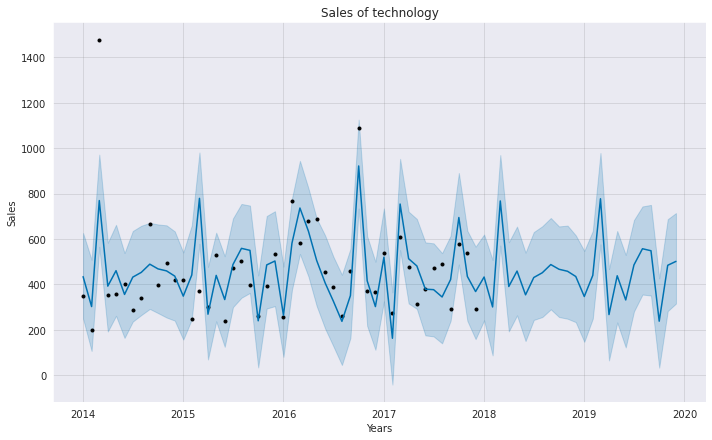

In [68]:
m_technology.plot(forecast_technology);
plt.title('Sales of technology')
plt.xlabel('Years')
plt.ylabel('Sales')

* From the graph, Higher sales was observed in the year 2016 during month of August-september in 2016.
* In 2018 and 2019 higher sales is predicted on month of march respeectively.
* Lower sales in 2018 is predicted on december and in 2019 it is predicted on October, which indicate lesser demand on these months.
Sales of technology products is predicted as same as previous years.

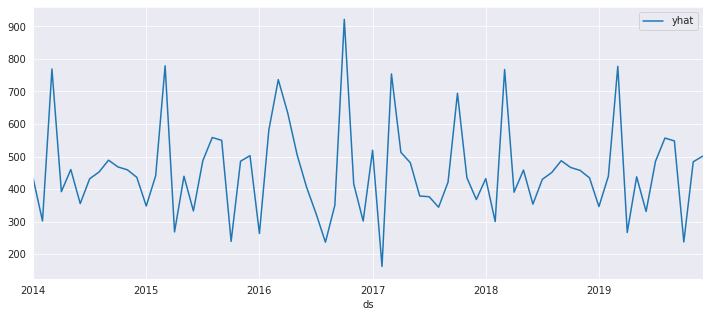

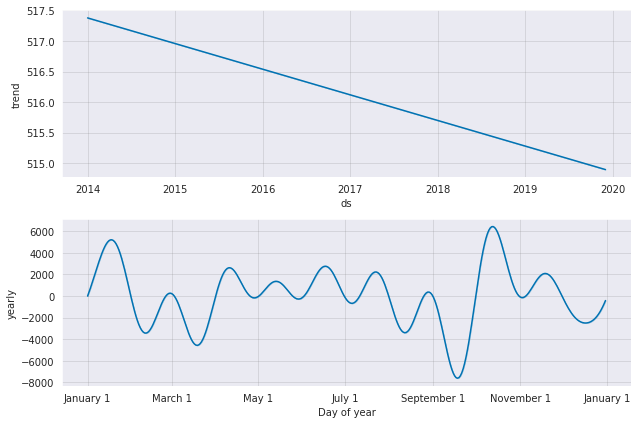

In [69]:
plot_plotly(m_technology, forecast_technology)
forecast_technology.plot(x='ds',y='yhat',figsize=(12,5))
m_technology.plot_components(forecast_technology);

In [70]:
plot_components_plotly(m_technology, forecast_technology)

A decreasing trend in sales is expected for technology items eventhough their sales are comparatively higher than other product categories.
 - high seasonality is expected on mid october and mid january.
 - lower seasonality on middle of september is predicted.

#### **Note:**
* Demand of office items is increasing as predicted from the above graphs.
* Trend of technology items linearly decreasing over years so demand of products is decreasing.
* Demand of furniture items is predicted as steadily decreasing. 

### **Conclusion:**
 - Demand of office items is increasing as predicted from the above graphs.
 - Demand of furniture items is predicted as steadily decreasing.
 - Demand of Technology items is slightly decreasing but it have comparatively large amount of sales.
 - Suitable Business strategies have to be implemented to improve sales of product category furniture.